# Unifying Distributed Training Strategies Under one Scheme

This notebook is a companion to [this paper](parallelsim.html.pdf). It shows how
various forms of parallelism can be rewritted as variants of a single scheduling
algorithm by specifying just two functions: a function that maps work to a
compute worker, and a function that maps weights to a storage worker. By just
changing these functions, we recover Pipeline Parallel, Data Parallel, Fully
Sharded Data Parallel, Looped Pipeline Parallel, their variants, and some new
forms of parallelism.


To run the notebook, execute

```
bazel run //cruise/mlp/robotorch2/lightning/strategies/notebooks:parallelsim_notebook
```

In [3]:
from importlib import reload
import numpy as np

import parallelsim

reload(parallelsim)

from parallelsim import Work, ComputeAndWeightWorkers

num_stages = 4
num_batches = 8

# Distributed Data Parallelism schemes

In these schemes, there is a 1:1 correspondence between workers and batches. Each worker processes every stage of the batch assigned to it in sequence.

In [4]:
def DistributedDataParallel(w: Work):
    return ComputeAndWeightWorkers(w.batch, w.batch)


parallelsim.simulate(num_batches, num_stages, num_batches, DistributedDataParallel)

SimulationStats(num_workers=8, num_stages=4, num_batches=8, schedule=<function DistributedDataParallel at 0x10e077e50>)

In [5]:
def FullyShardedDistributedDataParallel(w: Work):
    num_workers = num_batches
    return ComputeAndWeightWorkers(w.batch, w.stage % num_workers)


parallelsim.simulate(
    num_batches, num_stages, num_batches, FullyShardedDistributedDataParallel
)

SimulationStats(num_workers=8, num_stages=4, num_batches=8, schedule=<function FullyShardedDistributedDataParallel at 0x10d63c9d0>)

# Pipeline Parallelism Schemes

In these schemes, there is a 1:1 correspondence between workers and stages. Each worker processes just one stage of every batch.

In [6]:
def GPipe(w: Work):
    return ComputeAndWeightWorkers(w.stage, w.stage)


parallelsim.simulate(
    num_stages,
    num_stages,
    num_batches,
    GPipe,
    parallelsim.OldestStageFirst(num_stages, num_batches),
)

SimulationStats(num_workers=4, num_stages=4, num_batches=8, schedule=<function GPipe at 0x10e08e040>)

In [7]:
parallelsim.simulate(num_stages, num_stages, num_batches, GPipe)

SimulationStats(num_workers=4, num_stages=4, num_batches=8, schedule=<function GPipe at 0x10e08e040>)

# Looped Pipeline Parallelism

These schemes generalize Pipeline Parallism by allowing each worker to process
more than one stage of the pipelne. Each batch is assigned to a group of workers
based on its batch id, and if that group has fewer workers than there are
stages, each worker computes several stages of the pipeline for that batch.

In [8]:
num_workers_per_group = 2


def LoopedPipelineParallelism(w: Work):
    num_workers = num_stages

    def h(x, y):
        return (num_workers_per_group * y % num_workers) + (x % num_workers_per_group)

    worker = h(w.stage, w.batch)
    return ComputeAndWeightWorkers(worker, worker)


parallelsim.simulate(num_stages, num_stages, num_batches, LoopedPipelineParallelism)

SimulationStats(num_workers=4, num_stages=4, num_batches=8, schedule=<function LoopedPipelineParallelism at 0x10e08e160>)

In [9]:
def FullyShardedLoopedPipelineParallelism(w: Work):
    num_workers = num_stages

    def h(x, y):
        return (num_workers_per_group * y % num_workers) + (x % num_workers_per_group)

    return ComputeAndWeightWorkers(h(w.stage, w.batch), h(w.stage, w.stage))


parallelsim.simulate(
    num_stages, num_stages, num_batches, FullyShardedLoopedPipelineParallelism
)

SimulationStats(num_workers=4, num_stages=4, num_batches=8, schedule=<function FullyShardedLoopedPipelineParallelism at 0x10e008a60>)

# Illustrations with more workers

In [10]:
num_stages = 64
num_batches = 32
num_workers_per_group = 8

,Aggegrate Metrics
Latency,192.000000
Worker throughput (jobs / time / worker),0.666667
Max activation storage for a worker,64.000000
Mean activation storage for workers,64.000000


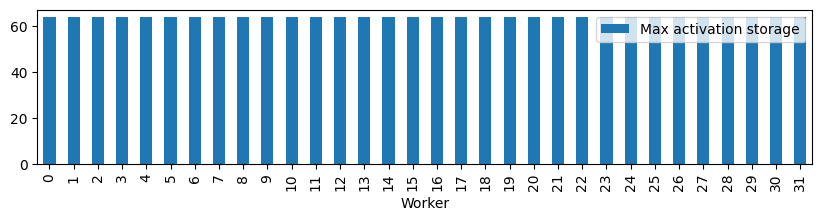

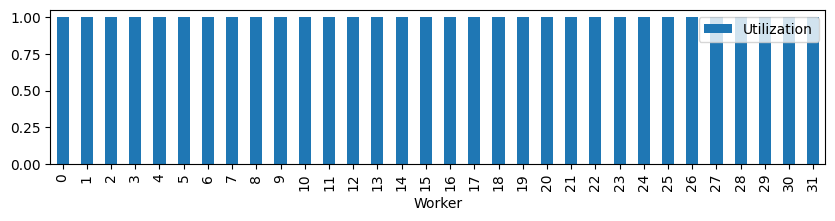

In [11]:
parallelsim.simulate(num_batches, num_stages, num_batches, DistributedDataParallel)

,Aggegrate Metrics
Latency,192.000000
Worker throughput (jobs / time / worker),0.666667
Max activation storage for a worker,64.000000
Mean activation storage for workers,64.000000


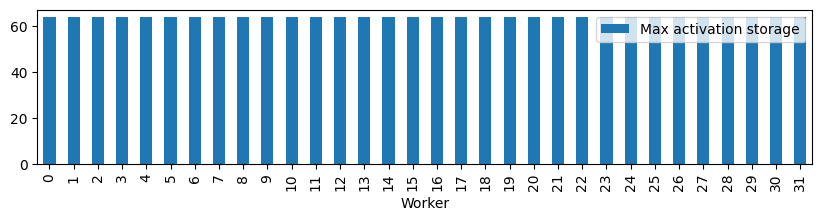

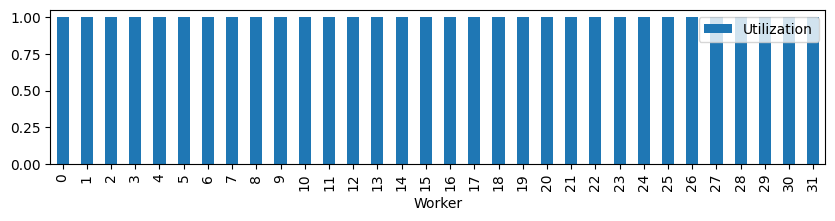

In [12]:
parallelsim.simulate(
    num_batches, num_stages, num_batches, FullyShardedDistributedDataParallel
)

,Aggegrate Metrics
Latency,285.000000
Worker throughput (jobs / time / worker),0.224561
Max activation storage for a worker,32.000000
Mean activation storage for workers,32.000000


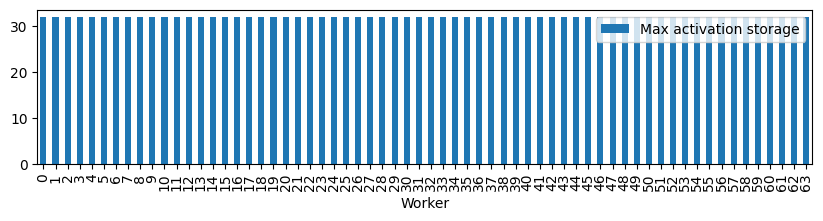

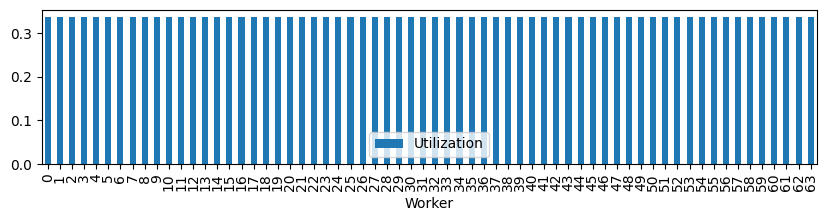

In [13]:
parallelsim.simulate(
    num_stages,
    num_stages,
    num_batches,
    GPipe,
    parallelsim.OldestStageFirst(num_stages, num_batches),
)

,Aggegrate Metrics
Latency,285.000000
Worker throughput (jobs / time / worker),0.224561
Max activation storage for a worker,32.000000
Mean activation storage for workers,29.250000


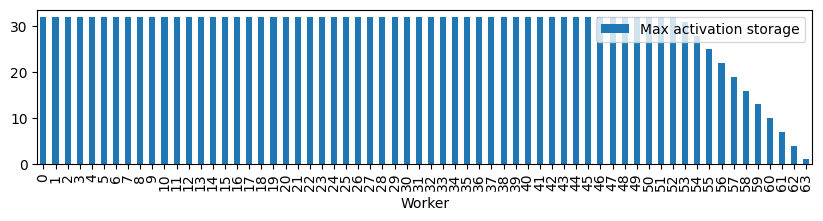

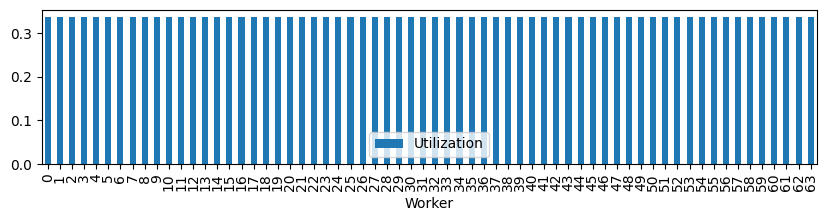

In [14]:
parallelsim.simulate(num_stages, num_stages, num_batches, GPipe)

,Aggegrate Metrics
Latency,201.000000
Worker throughput (jobs / time / worker),0.318408
Max activation storage for a worker,32.000000
Mean activation storage for workers,31.625000


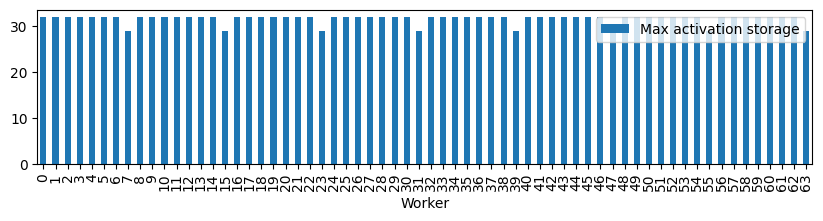

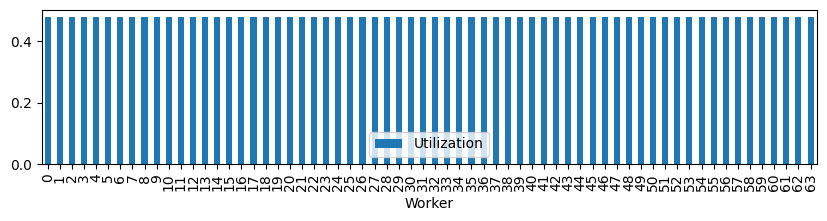

In [15]:
parallelsim.simulate(num_stages, num_stages, num_batches, LoopedPipelineParallelism)

,Aggegrate Metrics
Latency,201.000000
Worker throughput (jobs / time / worker),0.318408
Max activation storage for a worker,32.000000
Mean activation storage for workers,31.625000


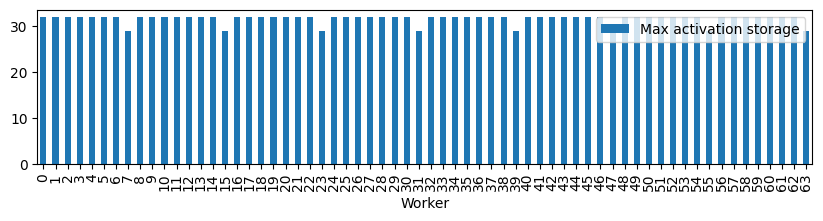

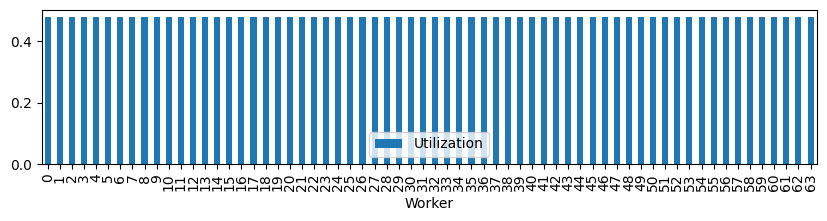

In [16]:
parallelsim.simulate(
    num_stages, num_stages, num_batches, FullyShardedLoopedPipelineParallelism
)

# Cuckoo Scheduling

In the activation storage above, activation storage is uneven across workers. Most workers store almost the entire set of activations, but some workers store less than half of that. This happens because in later stages of the pipeline, less time
elapses between the forward pass and the backward pass, so activations don't need to be kept alive for as long.

In cuckoo scheduling, we load more compute tasks on the workers that have to
store fewer activations.

In [28]:
num_stages = 64
num_batches = 128
num_workers_per_group = 8

,Aggegrate Metrics
Latency,573.000000
Worker throughput (jobs / time / worker),0.446771
Max activation storage for a worker,128.000000
Mean activation storage for workers,85.000000


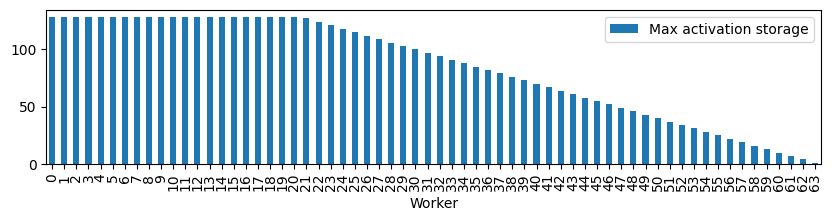

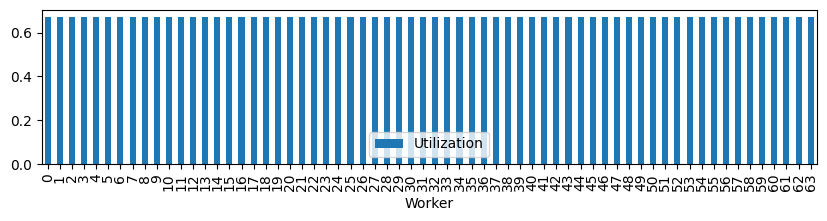

In [32]:
parallelsim.simulate(num_stages, num_stages, num_batches, GPipe)

,Aggegrate Metrics
Latency,739.000000
Worker throughput (jobs / time / worker),0.346414
Max activation storage for a worker,101.000000
Mean activation storage for workers,88.125000


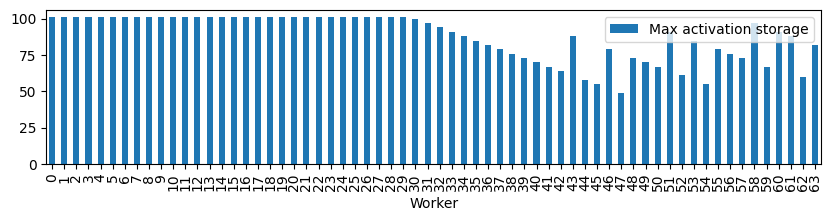

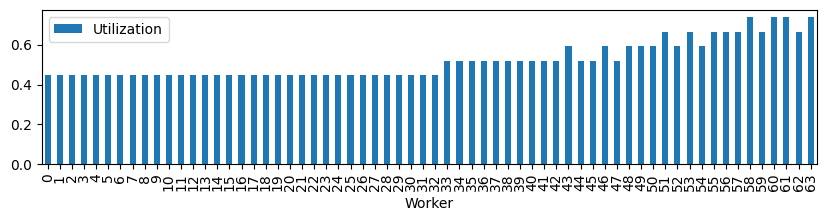

In [59]:
def CuckooParallelism(work: Work) -> ComputeAndWeightWorkers:
    num_workers = num_stages
    stage_cutoff = 33
    if (
        work.direction == parallelsim.Direction.BACKWARD
        and work.stage < stage_cutoff
        and work.batch > 100
    ):
        gap = 10
        compute_worker = np.int32(
            stage_cutoff
            + gap
            + np.sqrt(work.stage / stage_cutoff) * (num_workers - stage_cutoff - gap)
        )
        # This work will requires a worker to retain the
        # input activations for at least num_stages time steps. Spread this
        # storage burden on other workers by having them compute the backward
        # pass instead.
        return ComputeAndWeightWorkers(compute_worker, work.stage)
    return ComputeAndWeightWorkers(work.stage, work.stage)


parallelsim.simulate(num_stages, num_stages, num_batches, CuckooParallelism)

This reduced the max activation storage from 64 to 57 (an 11% reduction). It did this at the expense of reducing throughput ,from 0.33 jobs / worker / time to 0.288, a 16% reduction. Or equivalently, it increased latency from 381 time steps to 444 (a 16% increase).

Latency increases because the workers whose activation storage was not a bottleneck are now overloaded with compute. An alternative is to more that work onto dedicated workers.

,Aggegrate Metrics
Latency,573.000000
Worker throughput (jobs / time / worker),0.304185
Max activation storage for a worker,88.000000
Mean activation storage for workers,60.180851


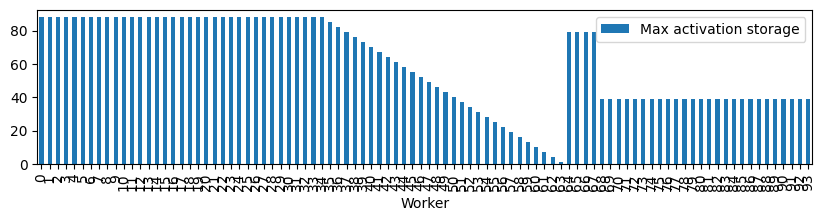

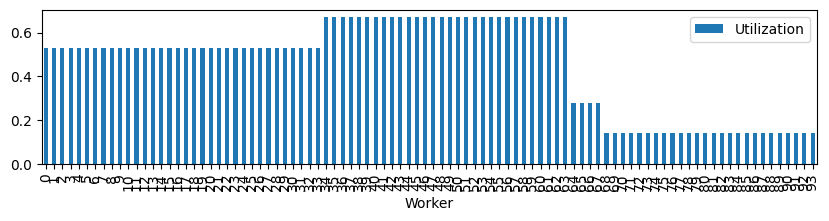

In [44]:
def OverFlowPipelineParallelism(work: Work) -> ComputeAndWeightWorkers:
    stage_cutoff = num_stages - num_overflow_workers
    if (
        work.direction == parallelsim.Direction.BACKWARD
        and work.stage < stage_cutoff
        and work.batch < 40
    ):
        return ComputeAndWeightWorkers(
            num_stages + (work.stage % num_overflow_workers), work.stage
        )
    return ComputeAndWeightWorkers(work.stage, work.stage)


num_overflow_workers = 30

parallelsim.simulate(
    num_stages + num_overflow_workers,
    num_stages,
    num_batches,
    OverFlowPipelineParallelism,
)